# Agent Based Models of Segregation

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2019 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

## Schelling's model

In 1969 Thomas Schelling published "[Models of Segregation](http://thinkcomplex.com/schell),
which proposed a simple model of racial segregation.

The Schelling model is a grid where each cell represents a house.  The houses are occupied by two kinds of agents,
labeled red and blue, in roughly equal numbers.  About 10% of the
houses are empty.

At any point in time, an agent might be happy or unhappy, depending
on the other agents in the neighborhood, where the
"neighborhood" of each house is the set of eight adjacent cells.

In one version of the model, agents are happy if they have at least
three neighbors like themselves, and unhappy if they have fewer than three.

The simulation proceeds by choosing an agent at random and checking
to see whether they are happy.  If so, nothing happens; if not,
the agent chooses one of the unoccupied cells at random and moves.

You will not be surprised to hear that this model leads to some
segregation, but you might be surprised by the degree.  

### Implementing the model

We will explore Schelling's model by implementing it in Python.  The following
function initializes the grid.

In [2]:
def make_grid(n):
    """Make an array with two types of agents.
    
    n: width and height of the array
    
    return: NumPy array
    """
    choices = np.array([0, 1, 2], dtype=np.int8)
    probs = [0.1, 0.45, 0.45]
    return np.random.choice(choices, (n, n), p=probs)

In [3]:
grid = make_grid(n=10)
grid

array([[2, 2, 2, 2, 1, 2, 1, 2, 1, 1],
       [2, 2, 2, 1, 2, 2, 2, 0, 2, 2],
       [2, 2, 2, 1, 2, 1, 2, 1, 1, 2],
       [1, 2, 1, 1, 2, 1, 2, 2, 2, 2],
       [1, 2, 2, 2, 1, 1, 1, 1, 2, 1],
       [1, 0, 2, 1, 2, 1, 2, 2, 1, 0],
       [2, 2, 1, 1, 2, 2, 1, 1, 2, 2],
       [1, 0, 1, 2, 2, 0, 1, 1, 1, 2],
       [2, 2, 0, 1, 2, 1, 0, 1, 1, 2],
       [1, 0, 2, 1, 1, 2, 2, 0, 0, 1]], dtype=int8)

The following function plots a visualization the grid.

In [4]:
from matplotlib.colors import LinearSegmentedColormap

# make a custom color map
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0]
cmap = LinearSegmentedColormap.from_list('cmap', colors)

def draw(grid):
    """Draws the grid.
    
    grid: NumPy array
    """
    # Make a copy because some implementations
    # of step perform updates in place.
    a = grid.copy()
    n, m = a.shape
    plt.axis([0, m, 0, n])
    plt.xticks([])
    plt.yticks([])

    options = dict(interpolation='none', alpha=0.8)
    options['extent'] = [0, m, 0, n]
    return plt.imshow(a, cmap, **options)

Here's what the random initial condition looks like.

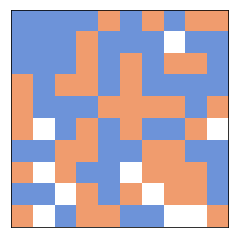

In [5]:
im = draw(grid)

### The step function

To simulate a time step in Schelling's model, we have to

1) Choose and unhappy agent.
2) Choose a random empty cell.
3) Move the agent.

The next few cells develop the functions we'll need.  As an exercise, you will assemble them into a `step` function.

First I'll compute `empty`, which is a boolean array that is `True` for the empty cells.

In [6]:
empty = (grid==0)
empty.sum()

10

To find the unhappy agents, we have to compute the number of same-color neighbors for each agent.  We'll do that using 2-D correlation.

As an example, we can compute the number of empty neighbors for each cell.

In [7]:
from scipy.signal import correlate2d

kernel = np.array([[1, 1, 1],
                   [1, 0, 1],
                   [1, 1, 1]], dtype=np.int8)

options = dict(mode='same', boundary='wrap')

correlate2d(empty, kernel, **options)

array([[1, 1, 1, 0, 0, 0, 2, 3, 3, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 1, 1, 0, 0, 0, 0, 0, 1, 1],
       [2, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [3, 2, 2, 0, 1, 1, 1, 0, 1, 1],
       [1, 1, 2, 1, 1, 1, 2, 1, 0, 0],
       [2, 3, 2, 1, 1, 2, 2, 3, 2, 1],
       [1, 1, 2, 1, 0, 1, 2, 2, 1, 1]], dtype=int8)

The following function computes the number of same-color neighbors for each agent.

In [8]:
def compute_num_same(grid):
    """For each cell, the number of same-color neighbors.
    
    grip: NumPy array
    
    return: new NumPy array
    """

    red = grid==1
    blue = grid==2

    # count red neighbors, blue neighbors, and total
    num_red = correlate2d(red, kernel, **options)
    num_blue = correlate2d(blue, kernel, **options)

    num_same = np.where(red, num_red, num_blue)
    
    return num_same

Here's what that looks like for the initial grid.

In [9]:
# for each cell, compute the fraction of neighbors with the same color
num_same = compute_num_same(grid)
num_same

array([[4, 6, 5, 4, 3, 5, 0, 3, 2, 3],
       [7, 8, 6, 2, 4, 5, 4, 4, 3, 5],
       [7, 6, 4, 3, 3, 1, 4, 1, 1, 6],
       [2, 5, 2, 3, 2, 4, 2, 4, 4, 4],
       [3, 3, 4, 4, 5, 4, 4, 2, 4, 4],
       [2, 5, 4, 3, 3, 4, 2, 3, 3, 4],
       [3, 2, 3, 3, 4, 4, 4, 5, 3, 3],
       [0, 4, 3, 3, 4, 4, 5, 6, 4, 5],
       [3, 2, 3, 3, 3, 2, 2, 4, 4, 2],
       [2, 6, 4, 3, 4, 3, 3, 2, 2, 4]], dtype=int8)

The mean of this array measures the average level of segregation.

In [10]:
num_same.mean()

3.54

`locs_where` is a wrapper on `np.nonzero` that returns a list of pairs, where each pair is the coordinate of an agent that meets a `condition`.

In [11]:
def locs_where(condition):
    """Find cells where a boolean array is True.
    
    condition: NumPy array
    
    return: list of coordinate pairs
    """
    ii, jj = np.nonzero(condition)
    return list(zip(ii, jj))

An agent is "unhappy" if they have fewer than 3 same-color neighbors.

Here are the locations of the unhappy agents.

In [12]:
threshold = 3

unhappy_locs = locs_where(num_same < threshold)
unhappy_locs

[(0, 6),
 (0, 8),
 (1, 3),
 (2, 5),
 (2, 7),
 (2, 8),
 (3, 0),
 (3, 2),
 (3, 4),
 (3, 6),
 (4, 7),
 (5, 0),
 (5, 6),
 (6, 1),
 (7, 0),
 (8, 1),
 (8, 5),
 (8, 6),
 (8, 9),
 (9, 0),
 (9, 7),
 (9, 8)]

During each time step, we'll choose a random unhappy agent.

The following function chooses a random tuple from a list.

In [13]:
def random_loc(locs):
    """Choose a random element from a list of tuples.
    
    locs: list of tuples
    
    return: tuple
    """
    index = np.random.choice(len(locs))
    return locs[index]

`source` is the random unhappy agent who decides to move.

In [14]:
source = random_loc(unhappy_locs)
source

(6, 1)

`dest` is the random empty cell they choose to move to.

In [15]:
empty_locs = locs_where(empty)
dest = random_loc(empty_locs)
dest

(8, 2)

The following function swaps `source` and `dest`.

In [16]:
def move(grid, source, dest):
    """Swap the agents at source and dest.
    
    grip: NumPy array
    source: location tuple
    dest: location tuple
    """
    grid[dest], grid[source] = grid[source], grid[dest]

In [17]:
move(grid, source, dest)

**Exercise:** Pull the code from the previous cells into a function that chooses an unhappy agent and moves them to a random empty cell.  It should compute and return the mean of `num_same`.

Note: If there are no unhappy cells, `step` should do nothing.

In [18]:
def step(grid, threshold=3):
    """Simulate one time step.
    
    grid: NumPy array
    threshold: number of same-color neighbors needed to be happy

    return: average number of same-color neighbors
    """
    num_same = compute_num_same(grid)
    unhappy_locs = locs_where(num_same < threshold)
    if len(unhappy_locs):
        source = random_loc(unhappy_locs)
        empty_locs = locs_where(empty)
        dest = random_loc(empty_locs)
        move(grid, source, dest)
    # FILL THIS IN!
    
    return num_same.mean()

In [19]:
# Solution goes here

Test your step function here.

In [20]:
step(grid)

3.55

Then run the following cells to see how segregation changes over time.

In [21]:
def decorate_seg():
    decorate(xlabel='Number of steps',
             ylabel='Average number of same-color neighbors',
             title='Schelling model')

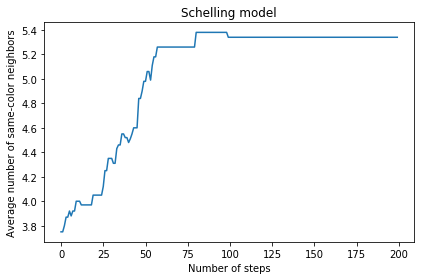

In [22]:
grid = make_grid(n=10)
segs = [step(grid) for i in range(200)]
plt.plot(segs)
decorate_seg()

**Exercise:** Experiment with different values of `threshold` and see what effect they have on the result.

### Bigger grid

Let's see how that looks on a bigger grid.

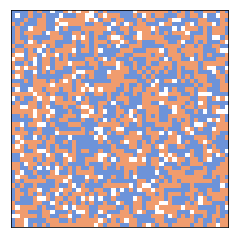

In [23]:
grid = make_grid(n=50)
im = draw(grid)

In [24]:
segs = [step(grid, threshold=3) for i in range(3000)]

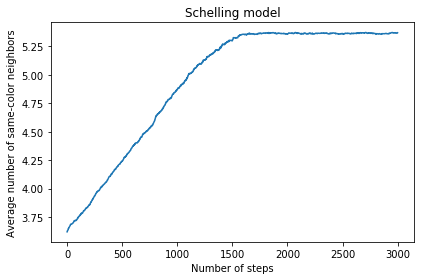

In [25]:
plt.plot(segs)
decorate_seg()

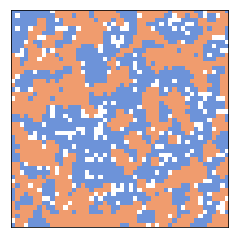

In [26]:
im = draw(grid)

The following figure shows three steps in the evolution of the grid.

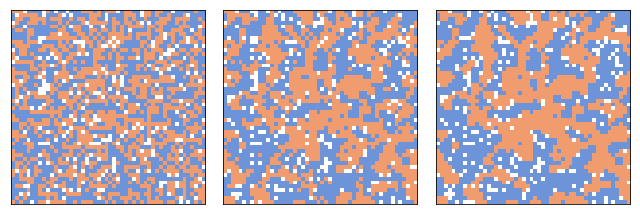

In [27]:
np.random.seed(17)

grid = make_grid(n=50)

# draw the initial grid
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
draw(grid)

# first update
plt.subplot(1,3,2)
for i in range(1000):
    step(grid)
draw(grid)

# second update
plt.subplot(1,3,3)
for i in range(1000):
    step(grid)
draw(grid)

plt.tight_layout()

**Exercise:** One more time, try out different values of `threshold`.  What value yields the biggest difference between `threshold` and the average number of same-color neighbors?

### Animation

The following functions animate the evolution of the grid.

In [28]:
from time import sleep
from IPython.display import clear_output

def animate(grid, frames, interval=None):
    """Animate the automaton.

    grid: NumPy array
    frames: number of frames to draw
    interval: time between frames in seconds
    """
    plt.figure()
    try:
        for i in range(frames-1):
            draw(grid)
            plt.show()
            if interval:
                sleep(interval)
            step(grid)
            clear_output(wait=True)
        draw(grid)
        plt.show()
    except KeyboardInterrupt:
        pass

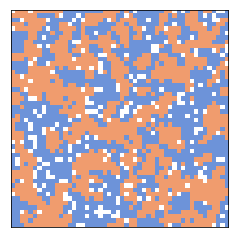

In [29]:
grid = make_grid(n=50)
animate(grid, frames=1000)

**Exercise:** Experiment with different starting conditions: for example, more or fewer empty cells, or unequal numbers of red and blue agents.

# The Big Sort

Bill Bishop, author of *The Big Sort*, argues that
American society is increasingly segregated by political
opinion, as people choose to live among like-minded neighbors.

The mechanism Bishop hypothesizes is not that people, like the agents
in Schelling's model, are more likely to move if they are
isolated, but that when they move for any reason, they are
likely to choose a neighborhood with people like themselves.

Let's write a version of Schelling's model to simulate
this kind of behavior and see if it yields similar degrees of
segregation.

We'll start with a random initial grid.

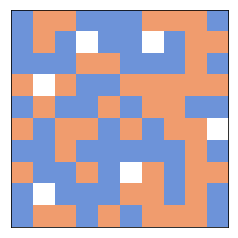

In [30]:
grid = make_grid(n=10)
im = draw(grid)

Write a few lines of code to choose a random occupied location, and call it `source`.

In [31]:
empty = (grid==0)
empty_locs = locs_where(empty)
empty_locs

[(1, 3), (1, 6), (3, 1), (5, 9), (7, 5), (8, 1)]

In [32]:
full_locs = locs_where(~empty)

In [33]:
source = random_loc(full_locs)
source

(1, 7)

Here's a list of random empty locations the `source` agent could move to.

In [34]:
num_comps = 2
dests = [random_loc(empty_locs) for i in range(num_comps)]
dests

[(5, 9), (3, 1)]

The following cell computes the number of neighbors in each location that are the same color as `source`.

In [35]:
same_color = (grid==grid[source])

num_same = correlate2d(same_color, kernel, **options)
num_same

array([[4, 4, 3, 4, 6, 4, 4, 1, 3, 4],
       [5, 6, 3, 5, 5, 5, 6, 2, 4, 5],
       [3, 4, 3, 5, 5, 4, 4, 2, 3, 2],
       [5, 5, 5, 4, 4, 4, 4, 3, 4, 5],
       [2, 3, 3, 4, 5, 3, 2, 2, 1, 2],
       [6, 4, 5, 5, 5, 6, 4, 4, 4, 5],
       [4, 4, 5, 4, 4, 5, 4, 3, 3, 1],
       [6, 5, 5, 7, 5, 5, 5, 3, 5, 4],
       [4, 5, 4, 5, 4, 3, 3, 1, 4, 3],
       [5, 4, 4, 5, 7, 3, 3, 1, 4, 5]], dtype=int8)

Now we can make a list with one tuple per destination, where the first element in each tuple is the number of same-color neighbors.

In [36]:
choices = [(num_same[dest], np.random.random(), dest) for dest in dests]

for choice in choices:
    print(choice)

(5, 0.2000641945788839, (5, 9))
(5, 0.8895465160935613, (3, 1))


Using the `max` function, we get the location with the highest number of same-color neighbors, with ties broken at random.

In [37]:
num, rand, dest = max(choices)
num, rand, dest

(5, 0.8895465160935613, (3, 1))

In [38]:
move(grid, source, dest)

Now pull all of that code into a step function.

In [39]:
def step(grid, num_comps=2):
    """Simulate one time step.
    
    grid: NumPy array
    num_comps: number of possible destinations the agent looks at
    
    return: average number of same-color neighbors
    """
    # FILL THIS IN

    return compute_num_same(grid).mean()

In [40]:
# Solution goes here

In [41]:
step(grid)

In [42]:
grid = make_grid(n=10)
segs = [step(grid) for i in range(200)]
plt.plot(segs)
decorate_seg()

**Exercise:** Experiment with different values of `num_comps` and see what effect they have on the result.

### Bigger grid

Let's see how that looks on a bigger grid.

In [43]:
grid = make_grid(n=50)
im = draw(grid)

In [44]:
segs = [step(grid) for i in range(2000)]

In [45]:
plt.plot(segs)
decorate_seg()

In [46]:
im = draw(grid)

The following figure shows three steps in the evolution of the grid.

In [47]:
np.random.seed(17)

grid = make_grid(n=50)

# draw the initial grid
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
draw(grid)

# first update
plt.subplot(1,3,2)
for i in range(1000):
    step(grid)
draw(grid)

# second update
plt.subplot(1,3,3)
for i in range(1000):
    step(grid)
draw(grid)

plt.tight_layout()

**Exercise:** One more time, try out different values of `num_comps`.

### Animation

Let's see what the animation looks like.

In [48]:
grid = make_grid(n=50)
animate(grid, frames=1000)